# SignXAI-Torch Basic Usage Example

This notebook demonstrates the usage of the SignXAI-Torch package with different visualization methods.

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from signxai_torch.methods.wrapper import calculate_relevancemap
from signxai_torch.utils.visualization import normalize_attribution

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

## Load and Preprocess Image

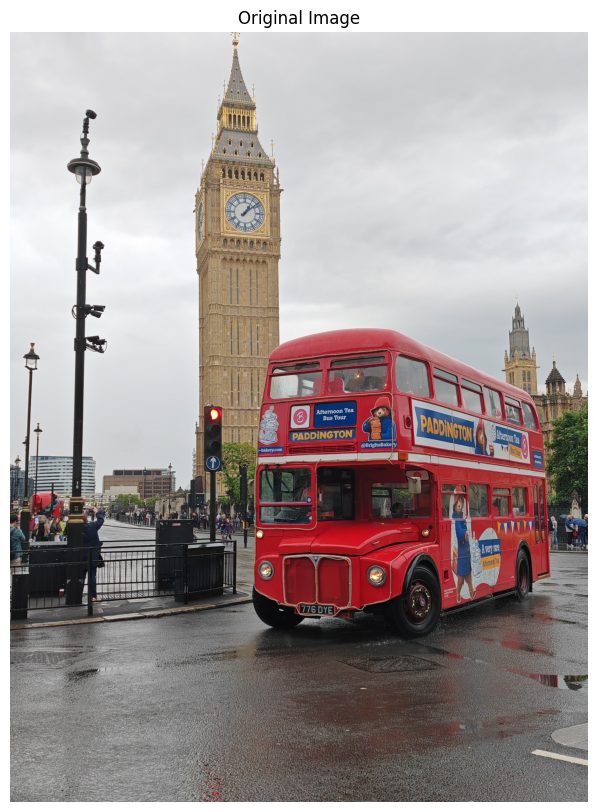

In [2]:
def load_and_preprocess_image(image_path):
    # Load image
    img = Image.open(image_path)
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Transform image
    input_tensor = transform(img)
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
    
    return img, input_tensor

# Load image
img, input_tensor = load_and_preprocess_image('testimage.jpg')

# Display original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

## Load Model

In [3]:
def prepare_model():
    """Prepare VGG16 model for analysis."""
    model = models.vgg16(pretrained=True)

    # Disable inplace operations
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            module.inplace = False

    # Replace classifier to properly handle dimensions
    classifier = nn.Sequential(
        nn.Flatten(),  # Explicit flattening
        model.classifier[0],  # Linear
        model.classifier[1],  # ReLU
        model.classifier[2],  # Dropout
        model.classifier[3],  # Linear
        model.classifier[4],  # ReLU
        model.classifier[5],  # Dropout
        nn.Sequential(        # Last layer without activation
            model.classifier[6],
            nn.Identity()
        )
    )
    model.classifier = classifier
    model.eval()
    return model

## Apply Different Methods

/home/honormagicbook14/anaconda3/envs/signxai-torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/honormagicbook14/anaconda3/envs/signxai-torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/honormagicbook14/Projects/PyCharm/SignXAIZennit/signxai_torch/methods/integrated.py:82: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated f

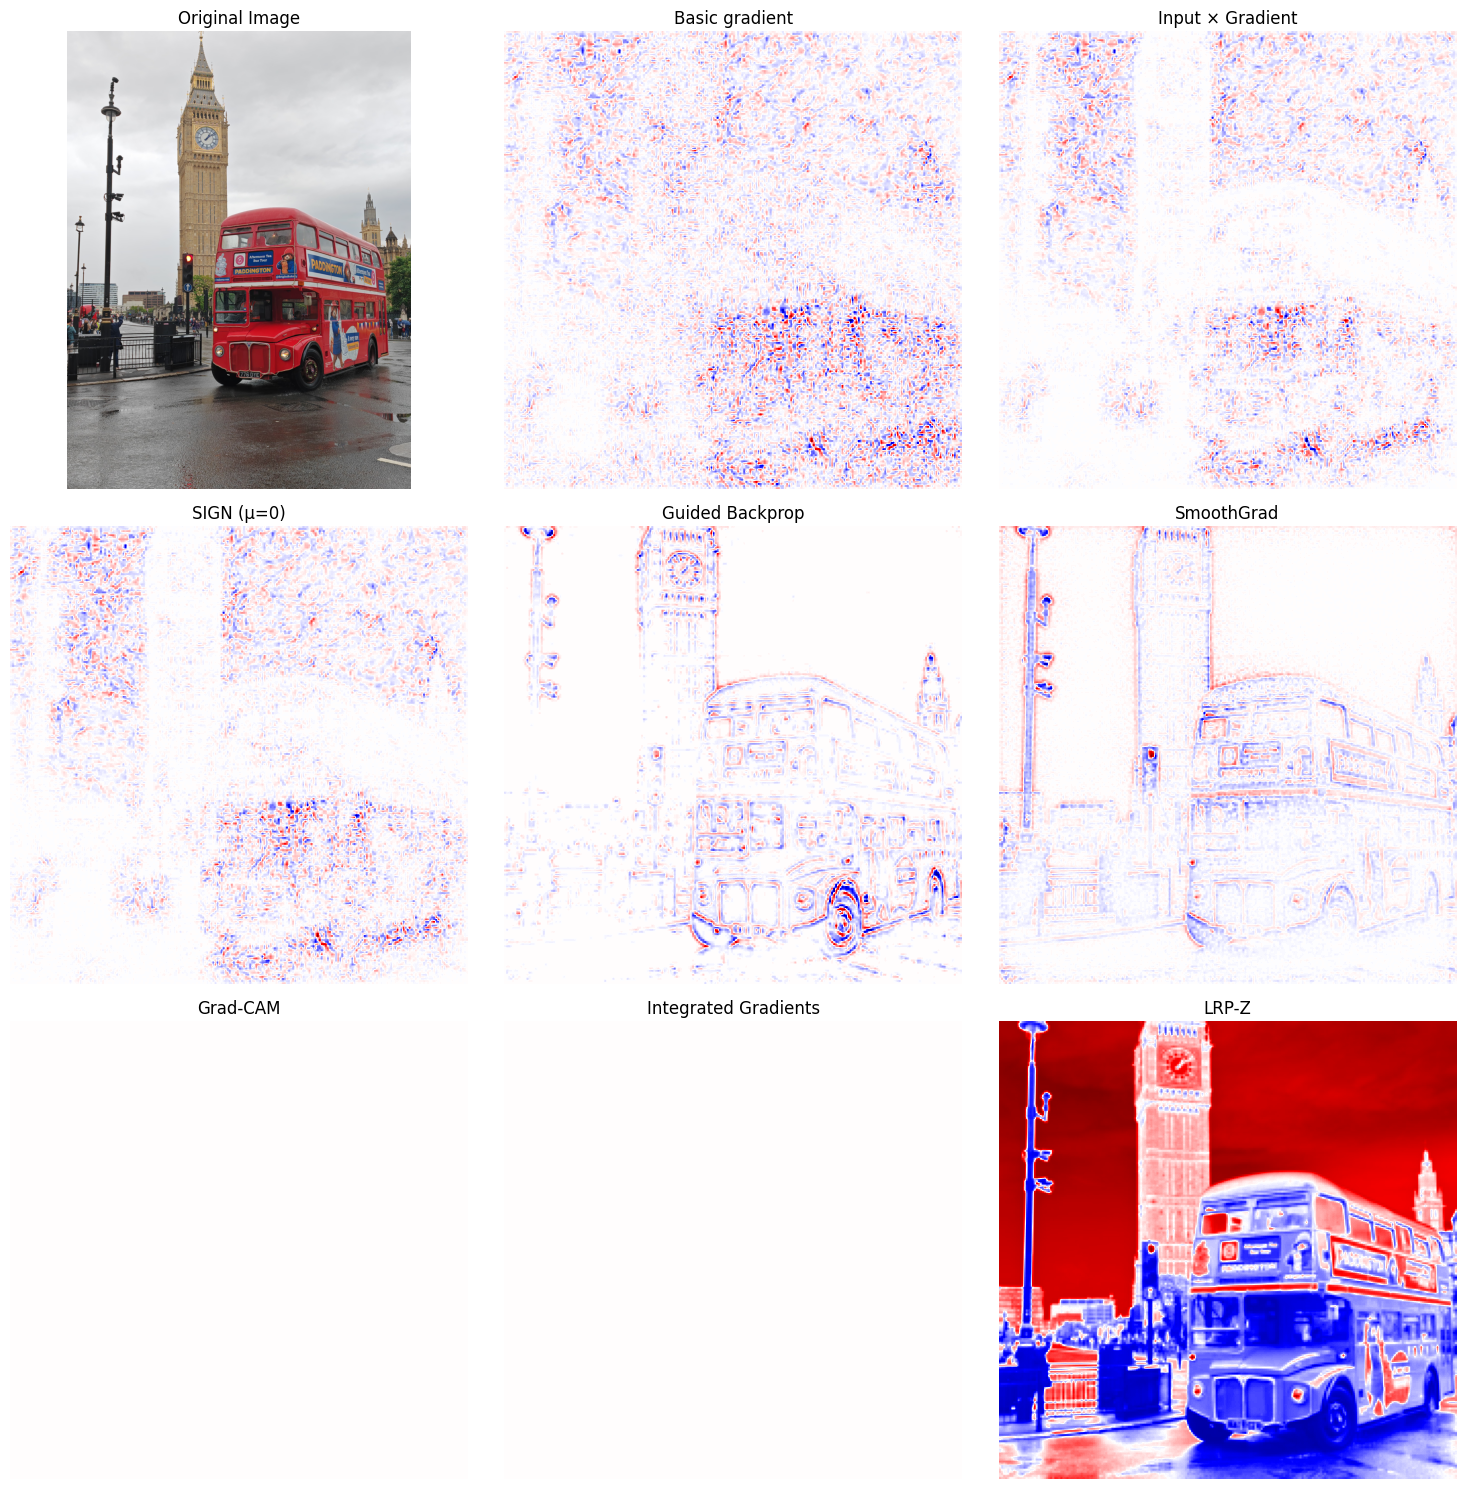

In [4]:
def visualize_attributions(img, input_tensor, model):
    """Visualize attributions from different methods."""
    # List of methods to demonstrate
    methods = {
        'gradient': 'Basic gradient',
        'gradient_x_input': 'Input × Gradient',
        'gradient_x_sign_mu_0': 'SIGN (μ=0)',
        'guided_backprop': 'Guided Backprop',
        'smoothgrad': 'SmoothGrad',
        'grad_cam_VGG16ILSVRC': 'Grad-CAM',
        'integrated_gradients': 'Integrated Gradients',
        'lrp_z': 'LRP-Z'  # Start with simpler LRP method
    }

    # Create visualization grid
    rows = (len(methods) + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
    axes = axes.ravel()

    # Show original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Apply each method
    for i, (method_name, method_title) in enumerate(methods.items(), start=1):
        try:
            # Important: Create fresh tensor for each method
            inputs = input_tensor.clone().detach().requires_grad_(True)

            attribution = calculate_relevancemap(
                method=method_name,
                inputs=inputs,
                model=model
            )

            if attribution is not None:
                # Compute visualization
                attribution_vis = normalize_attribution(
                    attribution[0].detach().sum(dim=0).cpu().numpy(),
                    symmetric=True
                )
                axes[i].imshow(attribution_vis, cmap='seismic', clim=(-1, 1))
                axes[i].set_title(method_title)
            else:
                axes[i].text(0.5, 0.5, 'Failed', horizontalalignment='center')
        except Exception as e:
            print(f'Failed to compute {method_title}: {str(e)}')
            axes[i].text(0.5, 0.5, 'Error', horizontalalignment='center')
        axes[i].axis('off')

    # Hide empty subplots
    for i in range(len(methods) + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and prepare image and model
    img, input_tensor = load_and_preprocess_image('testimage.jpg')
    model = prepare_model()

    # Generate visualizations
    visualize_attributions(img, input_tensor, model)

## Compare SIGN Variants

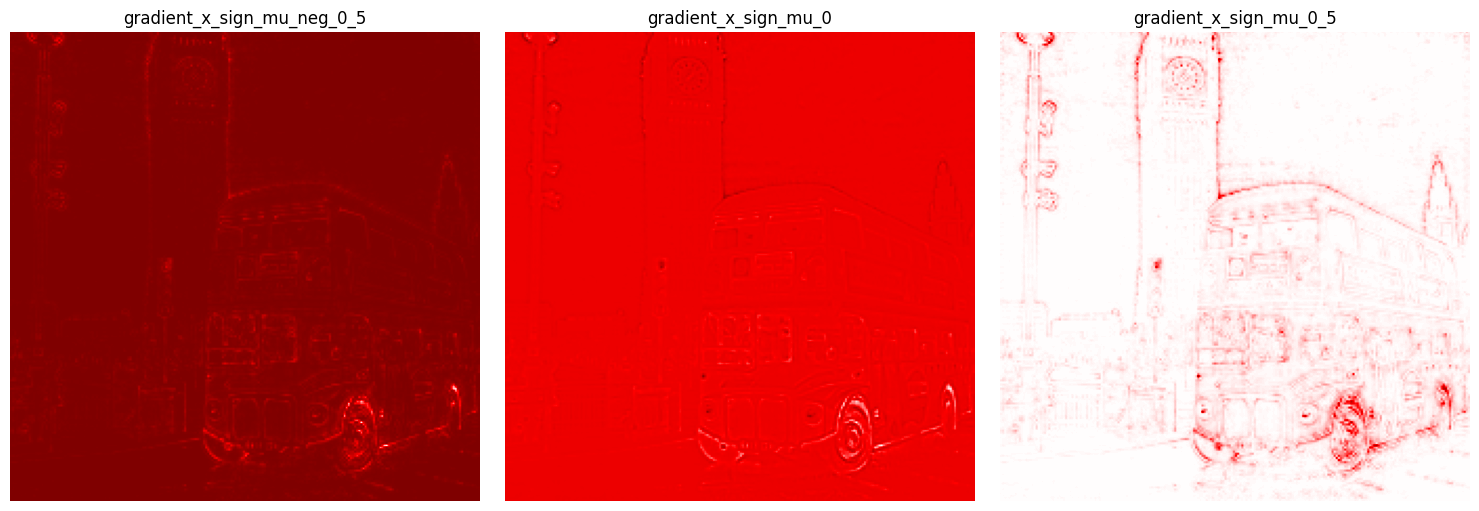

In [5]:
# Compare different mu values for SIGN
sign_methods = [
    'gradient_x_sign_mu_neg_0_5',
    'gradient_x_sign_mu_0',
    'gradient_x_sign_mu_0_5'
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, method in enumerate(sign_methods):
    attribution = calculate_relevancemap(method, input_tensor, model)
    attribution_vis = normalize_attribution(attribution[0].sum(dim=0).cpu().numpy())
    axes[i].imshow(attribution_vis, cmap='seismic', clim=(-1, 1))
    axes[i].set_title(method)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Compare LRP Variants

Failed to compute LRP-αβ (α=1,β=0): Error in LRP computation: The size of tensor a (25088) must match the size of tensor b (512) at non-singleton dimension 1


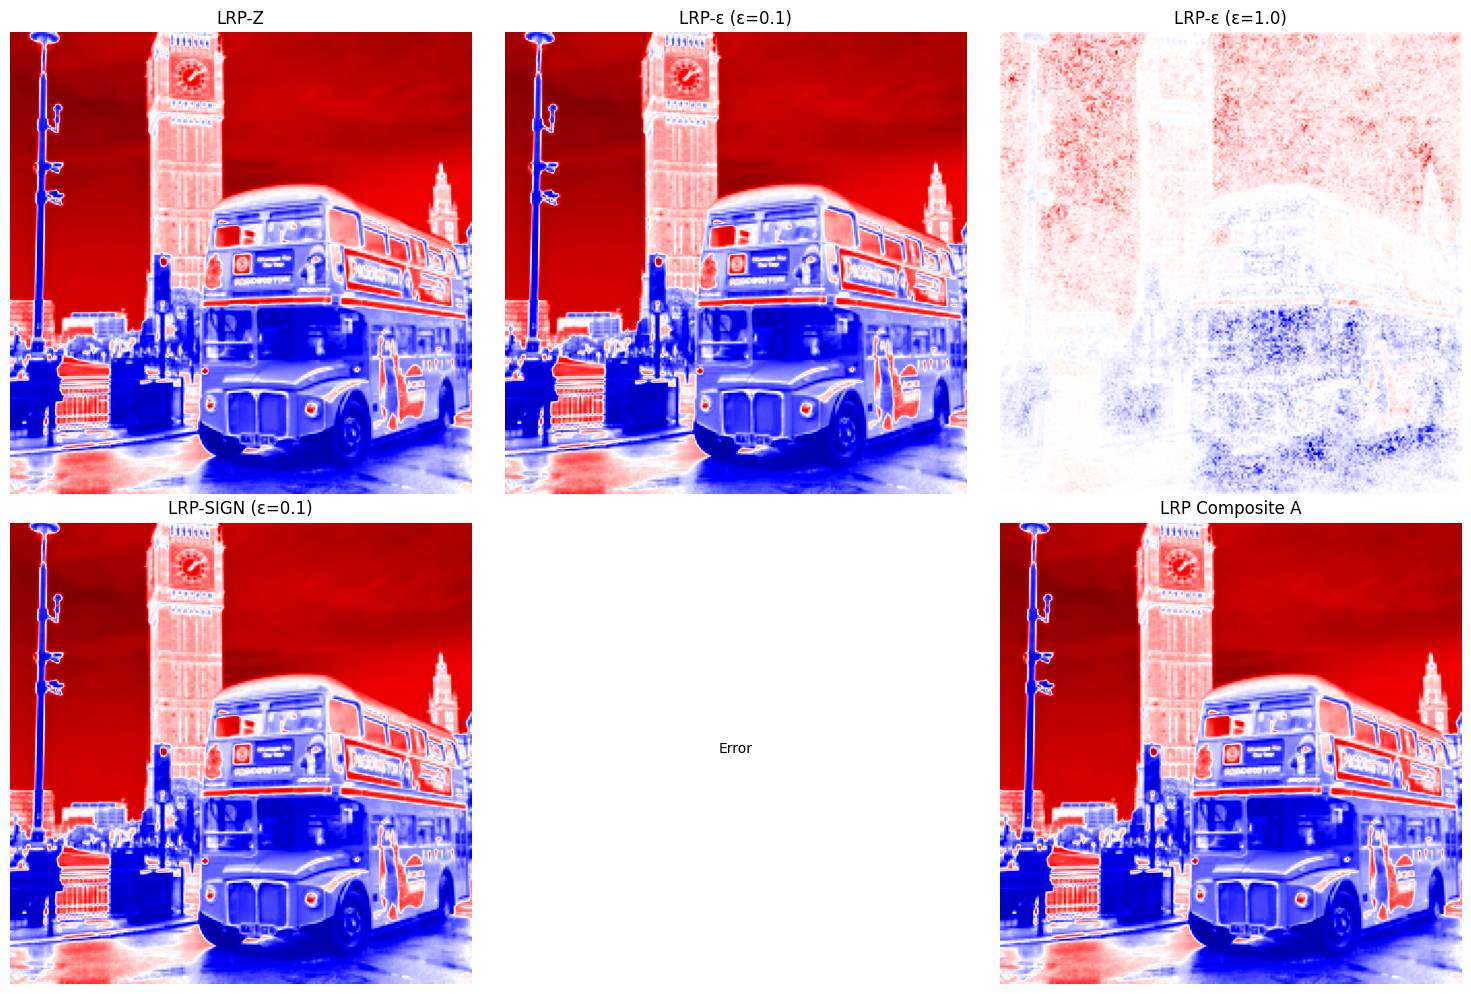

In [6]:
# Compare different LRP variants
def compare_lrp_variants(input_tensor, model):
    """Compare different LRP variants on the same input."""
    lrp_methods = {
        'lrp_z': 'LRP-Z',
        'lrp_epsilon_0_1': 'LRP-ε (ε=0.1)',
        'lrp_epsilon_1': 'LRP-ε (ε=1.0)',
        'lrpsign_epsilon_0_1': 'LRP-SIGN (ε=0.1)',
        'lrp_alpha_1_beta_0': 'LRP-αβ (α=1,β=0)',
        'lrp_sequential_composite_a': 'LRP Composite A'
    }

    # Create visualization grid
    rows = (len(lrp_methods) + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
    axes = axes.ravel()

    # Apply each method and visualize
    for i, (method_name, method_title) in enumerate(lrp_methods.items()):
        try:
            # Important: Create fresh tensor for each method
            inputs = input_tensor.clone().detach().requires_grad_(True)

            attribution = calculate_relevancemap(
                method=method_name,
                inputs=inputs,
                model=model
            )

            if attribution is not None:
                # Safely detach and convert to numpy
                attribution_np = attribution.detach().cpu().numpy()
                attribution_vis = normalize_attribution(
                    attribution_np[0].sum(axis=0),
                    symmetric=True
                )
                axes[i].imshow(attribution_vis, cmap='seismic', clim=(-1, 1))
                axes[i].set_title(method_title)
            else:
                axes[i].text(0.5, 0.5, 'Failed', horizontalalignment='center')
        except Exception as e:
            print(f'Failed to compute {method_title}: {str(e)}')
            axes[i].text(0.5, 0.5, 'Error', horizontalalignment='center')
        axes[i].axis('off')

    # Hide empty subplots
    for i in range(len(lrp_methods), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Load and process example
img, input_tensor = load_and_preprocess_image('testimage.jpg')
model = prepare_model()

# Run LRP comparison
compare_lrp_variants(input_tensor, model)